#Installations and Libraries

In [ ]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib
import talib as ta

In [ ]:
!git clone https://github.com/Shmuma/ptan.git
from ptan import ptan

In [ ]:
import gym
import numpy as np
import pandas as pd
from sklearn import preprocessing
import time
import matplotlib.pyplot as plt
import seaborn as sns
import collections

import sys, os

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils as nn_utils
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

import tensorflow as tf
%load_ext tensorboard

#Data

In [72]:
def data(start_train, end_train, start_test, end_test):

  prices = pd.read_csv(os.getcwd()+'/bitmex_data.csv', index_col=0)
  prices.volume[prices.volume == 0] = 100

  # Create new variables
  prices['close_change'] = (prices.close - prices.close.shift(1)) / prices.close.shift(1)
  prices['low_change'] = (prices.low - prices.low.shift(1)) / prices.low.shift(1)
  prices['high_change'] = (prices.high - prices.high.shift(1)) / prices.high.shift(1)
  prices['high_sc'] = (prices.high - prices.open) / prices.open
  prices['low_sc'] = (prices.low - prices.open) / prices.open
  prices["volume_change"] = (prices.volume - prices.volume.shift(1)) / prices.volume.shift(1)

  # Limit the range of values
  prices.loc[prices.volume_change>500, 'volume_change'] = 50
  prices.loc[prices.volume_change==0, 'volume_change'] = 0.5
  prices.loc[prices.close_change>0.1, 'close_change'] = 0.1
  prices.loc[prices.close_change<-0.1, 'close_change'] = -0.1
  prices.loc[prices.low_change>0.1, 'low_change'] = 0.1
  prices.loc[prices.low_change<-0.1, 'low_change'] = -0.1
  prices.loc[prices.high_change>0.1, 'high_change'] = 0.1
  prices.loc[prices.high_change<-0.1, 'high_change'] = -0.1
  prices.loc[prices.high_sc>0.1, 'high_sc'] = 0.1
  prices.loc[prices.low_sc<-0.1, 'low_sc'] = -0.1

  # Scale the inputs
  scaler=preprocessing.StandardScaler()
  scaler.fit(prices.loc[:, prices.columns[-6:]])
  prices.loc[start_train:end_train+1, prices.columns[-6:]] = scaler.transform(prices.loc[start_train:end_train+1, prices.columns[-6:]])
  prices.loc[start_test:end_test+1, prices.columns[-6:]] = scaler.transform(prices.loc[start_test:end_test+1, prices.columns[-6:]])
  
  train_data = prices.loc[start_train:end_train+1].reset_index(drop=True)
  test_data = prices.loc[start_test:end_test+1].reset_index(drop=True)
  
  return train_data, test_data

#Environment

In [21]:
class Actions():
    # 0 - hold, 1 - buy, -1 - sell
    action = np.array([-1, 0, 1])

In [22]:
class Environment_trade(gym.Env):
    """
    The simulated environment for trading. 
    """
    
    def __init__(self, prices, initial_balance_btc = 0.1, lookback_window = 50, max_trading_session = 10000, technical_window = 15):
        self.prices = prices.dropna().reset_index()
        self.initial_balance_btc = initial_balance_btc
        self.lookback_window = lookback_window
        self.action_space = gym.spaces.Discrete(n = Actions.action.size)
        self.trade_size = initial_balance_btc
        self.max_steps = max_trading_session
        self.technical_window = technical_window
        self.observation_space = gym.spaces.Box(low = -np.inf, high = np.inf,
                                                shape = (18, (self.lookback_window + 1)), dtype = np.float32)

    def reset(self, offset = None):
        self.done = False
        self.btc_held = 0
        self.net_gain = 0
        window = max(self.technical_window, self.lookback_window)
        if offset is not None:
          self.offset = offset
        else:
          self.offset = np.random.choice(self.prices.shape[0] - self.max_steps - (window * 4 + 1)) + window * 4 #because of macd
        self.steps_left = self.max_steps
        self.account_history = np.zeros((6 ,self.lookback_window + 1))
        self.technical_indicators = np.empty((10,0))
        for i in range(self.lookback_window):
          self.tech(self.offset - self.lookback_window + i, self.technical_window)
        self.state = self.cur_state()
        return self.state
        
    def shape(self):
        return self.observation_space.shape
    
    def cur_state(self):
        start=self.offset-self.lookback_window
        end=self.offset+1
        self.tech(self.offset, self.technical_window)
        cols = ['close_sc', 'high_sc', 'low_sc', 'close_change', 'high_change', 'low_change']
        state = np.vstack((
                           self.prices.close_change.values[start:end], self.prices.high_sc.values[start:end],
                           self.prices.low_sc.values[start:end], self.prices.high_change.values[start:end],
                           self.prices.low_change.values[start:end], self.prices.volume_change.values[start:end],
                           self.technical_indicators[:,-(self.lookback_window+1):],
                           self.account_history[[-3,-2],-(self.lookback_window+1):])) 
        return state.T
        
    def tech(self, end, n):
        end=end + 1
        start = end - n
        sma = ta.SMA(self.prices.close.values[start-1:end], n)
        sma = (sma[-1]/sma[-2]-1)*100
        ema = ta.EMA(self.prices.close.values[start-1:end], n)
        ema = (ema[-1]/ema[-2]-1)*100
        tema = ta.TEMA(self.prices.close.values[end - 3 * (n-1):end], n-1)
        tema = (tema[-1]/tema[-2]-1)*100
        rsi = ta.RSI(self.prices.close.values[start-1:end], n)[-1] / 100
        cmo = ta.CMO(self.prices.close.values[start-1:end], n)[-1] / 100
        roc = ta.ROC(self.prices.close.values[start-1:end], n)[-1]
        wil = ta.WILLR(self.prices.high.values[start-1:end], self.prices.low.values[start-1:end], self.prices.close.values[start-1:end], n)[-1] / 100
        cci = ta.CCI(self.prices.high.values[start-1:end], self.prices.low.values[start-1:end], self.prices.close.values[start-1:end], n)[-1] / 100
        macd = ta.MACD(self.prices.close.values[end - n * 3:end], n, n * 2, n * 0.75)[-1][-1]
        ppo = ta.PPO(self.prices.close.values[end - n * 2:end], n, n * 2)[-1]


        self.technical_indicators = np.append(self.technical_indicators, [[sma], [ema], [tema],
                                                                          [rsi], [cmo], [roc],
                                                                          [wil], [cci], [macd],
                                                                          [ppo]], axis = 1)

    def step(self, action):
        if self.done == True:
            reward = None
        else:
            change_net_gain, profit, btc_transaction = 0, 0, 0
            price_open = self.prices.close.iloc[self.offset]
            price_close = self.prices.close.iloc[self.offset + 1]
            price_low = self.prices.low.iloc[self.offset + 1]
            price_high = self.prices.high.iloc[self.offset + 1]

            act = Actions.action[action]
  
            if self.btc_held > 0 and act > 0:
                act = 0
            elif self.btc_held < 0 and act < 0:
                act = 0


            btc_transaction = self.trade_size * act
            self.btc_held += btc_transaction

            profit += (price_close - price_open) / price_open * self.btc_held

            self.offset += 1

            change_net_gain = profit / self.initial_balance_btc * 100
            self.net_gain += profit

            self.account_history = np.append(self.account_history, [[btc_transaction / self.initial_balance_btc], [0], 
                                                                    [change_net_gain], [self.net_gain / self.initial_balance_btc *100],
                                                                    [self.btc_held / self.initial_balance_btc], [0]], axis=1)
            
            reward = change_net_gain
            reward = np.clip(reward, -3, 3)

            self.state = self.cur_state()
            self.steps_left -= 1
            
            if self.steps_left == 0 or self.net_gain <= -self.initial_balance_btc or self.offset == len(self.prices)-1:
                self.done = True
            
        return self.state, reward, self.done, {}

#Experience Source

In [33]:
Experience = collections.namedtuple('Experience', ['state', 'action', 'reward', 'done'])
ExperienceFirstLast = collections.namedtuple('ExperienceFirstLast', ('state', 'action', 'reward', 'last_state'))

In [89]:
class ExperienceSource:
    """
    Simple n-step experience source using single or multiple environments
    Every experience contains n list of Experience entries
    """
    def __init__(self, env, agent, steps_count=2):

        assert isinstance(env, (gym.Env, list, tuple))
        assert isinstance(steps_count, int)
        assert steps_count >= 1
        if isinstance(env, (list, tuple)):
            self.pool = env
        else:
            self.pool = [env]
        self.agent = agent
        self.steps_count = steps_count
        self.total_rewards = []
        self.net_gains = []
        self.position = []
        self.traded_amount = []
        self.ret = []

    def __iter__(self):
        states, histories, cur_rewards= [], [], []
        for env in self.pool:
            obs = env.reset()
            states.append(obs)
            histories.append(collections.deque(maxlen=self.steps_count))
            cur_rewards.append(0.0)

        while True:
            actions = self.agent(np.array(states))

            for idx, (env, action) in enumerate(zip(self.pool, actions)):
                next_state, r, is_done, _ = env.step(action)
                state = states[idx]
                history = histories[idx]
                cur_rewards[idx] += r
                history.append(Experience(state=state, action=action, reward=r, done=is_done))
                
                if len(history) == self.steps_count:
                    yield tuple(history)
                states[idx] = next_state
                if is_done:
                    # in case of very short episode (shorter than our steps count), send gathered history
                    if 0 < len(history) < self.steps_count:
                        yield tuple(history)

                    self.total_rewards.append(cur_rewards[idx])
                    self.net_gains.append(env.account_history[3][-1])
                    self.position.append(env.account_history[4].mean())
                    self.traded_amount.append(abs(env.account_history[0]).sum())
                    self.ret.append(env.account_history[1].sum())
                    cur_rewards[idx] = 0.0

                    states[idx] = env.reset() 
                    history.clear()

    def pop_total_rewards(self):
        r = self.total_rewards
        ng = self.net_gains
        pos = self.position
        tr = self.traded_amount
        ret = self.ret
        if r:
            self.total_rewards = []
            self.net_gains = []
            self.position = []
            self.traded_amount = []
            self.ret = []
        return r, ng, pos, tr, ret

class ExperienceSourceFirstLast(ExperienceSource):

    def __init__(self, env, agent, gamma, steps_count=1):
        assert isinstance(gamma, float)
        super(ExperienceSourceFirstLast, self).__init__(env, agent, steps_count+1)
        self.gamma = gamma
        self.steps = steps_count

    def __iter__(self):
        for exp in super(ExperienceSourceFirstLast, self).__iter__():
            if exp[-1].done and len(exp) <= self.steps:
                last_state = None
                elems = exp
            else:
                last_state = exp[-1].state
                elems = exp[:-1]
            total_reward = 0.0
            for e in reversed(elems):
                total_reward *= self.gamma
                total_reward += e.reward
            yield ExperienceFirstLast(state=exp[0].state, action=exp[0].action,
                                      reward=total_reward, last_state=last_state)

#Agent

In [35]:
def default_states_preprocessor(states):
    """Convert list of states into the form suitable for model. By default we assume Variable"""

    if states.ndim == 2:
        np_states = np.expand_dims(states, 0)
    else:
        np_states = np.array([np.array(s, copy=False) for s in states], copy=False)
    return torch.tensor(np_states)

In [36]:
class PolicyAgent():
    def __init__(self, model, device="cpu", apply_softmax=False, preprocessor=default_states_preprocessor):
        self.model = model
        self.device = device
        self.apply_softmax = apply_softmax
        self.preprocessor = preprocessor

    @torch.no_grad()
    def __call__(self, states):

        actions = []

        if self.preprocessor is not None:
            states = self.preprocessor(states)
            if torch.is_tensor(states):
                states = states.to(self.device)
        probs_v, vals = self.model(states)
        if self.apply_softmax:
            probs_v = F.softmax(probs_v, dim=1)
        probs = probs_v.data.cpu().numpy()

        for prob in probs:
            actions.append(np.random.choice(len(prob), p=prob))
        return np.array(actions)

In [37]:
class PolicyAgentEvaluation():
    def __init__(self, model, device="cpu", apply_softmax=False, preprocessor=default_states_preprocessor):
        self.model = model
        self.device = device
        self.apply_softmax = apply_softmax
        self.preprocessor = preprocessor

    @torch.no_grad()
    def __call__(self, states):

        actions = []

        if self.preprocessor is not None:
            states = self.preprocessor(states)
            if torch.is_tensor(states):
                states = states.to(self.device)
        probs_v, vals = self.model(states)
        if self.apply_softmax:
            probs_v = F.softmax(probs_v, dim=1)
        probs = probs_v.data.cpu().numpy()

        for prob in probs:
            actions.append(np.argmax(prob))
        return np.array(actions)

#Unpack

In [38]:
def unpack_batch(batch, net, gamma, rew_steps, device='cpu'):

    states = []
    actions = []
    rewards = []
    not_done_idx = []
    last_states = []
    for idx, exp in enumerate(batch):
        states.append(np.array(exp.state, copy=False))
        actions.append(int(exp.action))
        rewards.append(exp.reward)
        if exp.last_state is not None:
            not_done_idx.append(idx)
            last_states.append(np.array(exp.last_state, copy=False))

    states_v = torch.FloatTensor(np.array(states, copy=False)).to(device)
    actions_t = torch.LongTensor(actions).to(device)

    # handle rewards
    rewards_np = np.array(rewards, dtype=np.float32)
    if not_done_idx:
        last_states_v = torch.FloatTensor(np.array(last_states, copy=False)).to(device)
        last_vals_v = net(last_states_v)[1]
        last_vals_np = last_vals_v.data.cpu().numpy()[:, 0]
        last_vals_np *= gamma ** rew_steps
        rewards_np[not_done_idx] += last_vals_np

    ref_vals_v = torch.FloatTensor(rewards_np).to(device)

    return states_v, actions_t, ref_vals_v

#A2C

In [39]:
class A2C_LSTM(nn.Module):
  def __init__(self, input_shape, hidden_dim, n_layers, n_actions):
    super(A2C_LSTM, self).__init__()

    self.lstm = nn.LSTM(input_shape[0], hidden_dim, n_layers, batch_first=True)

    self.policy = nn.Sequential(
      nn.LayerNorm(hidden_dim),
      nn.Linear(hidden_dim, 128),
      nn.ReLU(),
      nn.LayerNorm(128),
      nn.Linear(128, n_actions))
    
    self.value = nn.Sequential(
      nn.LayerNorm(hidden_dim),
      nn.Linear(hidden_dim, 128),
      nn.ReLU(),
      nn.LayerNorm(128),
      nn.Linear(128, 1))

  def forward(self, x):
      fx = x.float()
      out, (hid_cell, state_cell) = self.lstm(fx)
      fxx = hid_cell[-1]
      return self.policy(fxx), self.value(fxx)

#Trackers

###Regular

In [40]:
class RewardTracker:
    def __init__(self, writer, n_env):
        self.writer = writer
        self.n_env = n_env

    def __enter__(self):
        self.total_rewards = []
        self.env_rewards = []
        self.net_gain = []
        self.position = []
        self.traded = []
        return self

    def __exit__(self, *args):
        self.writer.close()

    def reward(self, reward, net_gain, position, traded, frame):
        self.total_rewards.append(reward)
        self.env_rewards.append(reward)
        self.net_gain.append(net_gain)
        self.position.append(position)
        self.traded.append(traded)
        mean_reward = np.mean(self.total_rewards[-self.n_env * 10:])
        
        if len(self.env_rewards) == self.n_env:
          print("%d: done %d trading sessions, reward %.3f, net gain %.1f, position %.2f, total_traded %.1f" % (
              frame, len(self.env_rewards), np.mean(self.total_rewards), np.mean(self.net_gain),
              np.mean(self.position), np.mean(self.traded)))
          self.env_rewards = []
          self.net_gain = []
          self.position = []
          self.traded = []

        sys.stdout.flush()

        self.writer.add_scalar("reward_mean", mean_reward, frame)
        self.writer.add_scalar("net_gain", net_gain, frame)
        self.writer.add_scalar("av_position", position, frame)
        self.writer.add_scalar("total_trade", traded, frame)

###Val

In [41]:
class Validation_tracker:
  def __init__(self, writer, val_data, env, agent):
        self.writer = writer
        self.data = val_data
        self.env = env
        self.agent = agent

  def __enter__(self):
        self.reward = []
        self.net_gain = []
        self.position = []
        return self
    
  def __exit__(self, *args):
        self.writer.close()

  def performance(self, frame):
    net_gains, rewards, positions = [], [], []
    
    off = 100 
    to_continue = True
    while len(self.env.prices) - off > 100:
      state = self.env.reset(offset = off)
      reward = 0
      while True:
        action = self.agent(np.array(state))
        state, r, done, _ = self.env.step(int(action))
        reward += r
        off = self.env.offset
        if done: break
      net_gains.append(self.env.account_history[3][-1])
      rewards.append(reward)
      positions.append(self.env.account_history[4].mean())

    if not self.net_gain or np.mean(net_gains) > max(self.net_gain):
      torch.save(net.state_dict(), 'parameters_best_val_{}'.format(np.round(np.mean(net_gains),1)))
      print("Best validation, parameters saved.")
    self.reward.append(np.mean(rewards))
    self.net_gain.append(np.mean(net_gains))
    self.position.append(np.mean(positions))
    print("Validation %d: mean reward %.3f, mean gain %.1f, mean position %.2f" % (
          frame, self.reward[-1], self.net_gain[-1], self.position[-1]))
    
    self.writer.add_scalar("val_reward", self.reward[-1], frame)
    self.writer.add_scalar("val_net_gain", self.net_gain[-1], frame)
    self.writer.add_scalar("val_position", self.position[-1], frame)

#Arguments

In [100]:
# Hyperparameters

GAMMA = 0.98
LEARNING_RATE = 1e-5
W_D = 0.01
ENTROPY_BETA = 0.05
VALUE_BETA = 0.15
POLICY_BETA = 1
BATCH_SIZE = 128
NUM_ENVS = 128
LOOKBACK_WINDOW = 25
MTS = 500
HIDDEN_DIM = 256
N_LAYERS = 2

REWARD_STEPS = 3
CLIP_GRAD = 0.01

stop_after = 10000000
SYNC_TARGET_FRAMES = 5000

In [ ]:
train_data, test_data = data(1, 70000, 70000, 100000)

#Training Loop

In [101]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

make_env = lambda: Environment_trade(train_data, lookback_window = LOOKBACK_WINDOW, max_trading_session = MTS)
envs = [make_env() for _ in range(NUM_ENVS)]
writer = SummaryWriter(comment="Trading")

net = A2C_LSTM(envs[0].observation_space.shape, HIDDEN_DIM, N_LAYERS, envs[0].action_space.n).to(device)
tgt_net = A2C_LSTM(envs[0].observation_space.shape, HIDDEN_DIM, N_LAYERS, envs[0].action_space.n).to(device)

agent = PolicyAgent(lambda x: net(x), apply_softmax=True, device=device)
exp_source = ExperienceSourceFirstLast(envs, agent, gamma=GAMMA, steps_count=REWARD_STEPS)

optimizer = optim.AdamW(net.parameters(), lr=LEARNING_RATE, weight_decay=W_D)

batch = []
step = 0

In [102]:
env_val = Environment_trade(test_data, lookback_window = LOOKBACK_WINDOW, max_trading_session = MTS)
val_agent = PolicyAgentEvaluation(lambda x: net(x), apply_softmax=True, device=device)

In [103]:
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv1d:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
_=net.apply(init_weights)

In [104]:
tgt_net=net
_=net.train()
_=tgt_net.train()

In [ ]:
%tensorboard --logdir runs

In [ ]:
with RewardTracker(writer, n_env=NUM_ENVS) as tracker:
      with ptan.common.utils.TBMeanTracker(writer, batch_size=10) as tb_tracker:
          with Validation_tracker(writer, test_data, env_val, val_agent) as val_tracker:
            for exp in exp_source:
                step += 1
                batch.append(exp)

                if step % 1000000 == 0:
                  val_tracker.performance(step)
                if step == stop_after: 
                  torch.save(net.state_dict(), 'parameters_after_{}m_iterations'.format(stop_after / 1e6))
                  print("Parameters saved after {}m iterations".format(step / 1e6))
                  break

                # handle new rewards
                new_rewards, net_gains, positions, traded, _ = exp_source.pop_total_rewards()
                if new_rewards:
                    tracker.reward(new_rewards[0], net_gains[0], positions[0], traded[0], step)
              
                if step % SYNC_TARGET_FRAMES == 0:
                    tgt_net.load_state_dict(net.state_dict())
                
                if len(batch) < BATCH_SIZE:
                    continue

                states_v, actions_t, vals_ref_v = unpack_batch(batch, tgt_net, GAMMA, REWARD_STEPS, device=device)
                batch.clear()

                optimizer.zero_grad()
                logits_v, value_v = net(states_v)
                loss_value_v = VALUE_BETA * F.mse_loss(value_v.squeeze(-1), vals_ref_v)

                log_prob_v = F.log_softmax(logits_v, dim=1)
                adv_v = vals_ref_v - value_v.detach()
                log_prob_actions_v = adv_v * log_prob_v[range(BATCH_SIZE), actions_t]
                loss_policy_v = -log_prob_actions_v.mean() * POLICY_BETA

                prob_v = F.softmax(logits_v, dim=1)
                entropy_loss_v = ENTROPY_BETA * (prob_v * log_prob_v).sum(dim=1).mean()

                # calculate policy gradients only
                loss_policy_v.backward(retain_graph=True)
                grads = np.concatenate([p.grad.data.cpu().numpy().flatten()
                                        for p in net.parameters()
                                        if p.grad is not None])

                # apply entropy and value gradients
                loss_v = entropy_loss_v + loss_value_v
                loss_v.backward()
                nn_utils.clip_grad_norm_(net.parameters(), CLIP_GRAD)
                optimizer.step()
                # get full loss
                loss_v += loss_policy_v


                tb_tracker.track("advantage",       adv_v, step)
                tb_tracker.track("values",          value_v, step)
                tb_tracker.track("batch_rewards",   vals_ref_v, step)
                tb_tracker.track("loss_entropy",    -entropy_loss_v, step)
                tb_tracker.track("loss_policy",     loss_policy_v, step)
                tb_tracker.track("loss_value",      loss_value_v, step)
                tb_tracker.track("loss_total",      loss_v, step)
                tb_tracker.track("grad_l2",         np.sqrt(np.mean(np.square(grads))), step)
                tb_tracker.track("grad_max",        np.max(np.abs(grads)), step)
                tb_tracker.track("grad_var",        np.var(grads), step)

#Active Learning

In [128]:
class New_tracker:
  def __init__(self, env, agent):
        self.env = env
        self.agent = agent

  def __enter__(self):
        self.net_gain = []
        self.position = []
        return self
    
  def __exit__(self, *args):
        1==1

  def performance(self):
    off = 100 
    state = self.env.reset(offset = off)
    price_open = self.env.prices.close.iloc[off]
    while True:
      action = self.agent(np.array(state))
      state, r, done, _ = self.env.step(int(action))
      if done:
        break
    price_close = self.env.prices.close.iloc[-1]
    base_return = (price_close - price_open)/price_open * 100

    print("Validation: mean gain %.1f, mean position %.2f, baseline %.2f" % (self.env.account_history[3][-1],
                                                              self.env.account_history[4].mean(),
                                                              base_return))

    return self.env.account_history[3][-1], base_return

In [ ]:
model, base, long_strategy = [], [], []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
writer = SummaryWriter(comment="Trading")

net = A2C_LSTM(envs[0].observation_space.shape, HIDDEN_DIM, N_LAYERS, envs[0].action_space.n).to(device)
net.load_state_dict(torch.load(os.getcwd()+'/parameters_after_{}m_iterations'.format(stop_after / 1e6), map_location=device))
tgt_net = A2C_LSTM(envs[0].observation_space.shape, HIDDEN_DIM, N_LAYERS, envs[0].action_space.n).to(device)
tgt_net=net
net.train()
tgt_net.train()
base_net = A2C_LSTM(envs[0].observation_space.shape, HIDDEN_DIM, N_LAYERS, envs[0].action_space.n).to(device)
base_net.load_state_dict(torch.load(os.getcwd()+'/parameters_after_{}m_iterations'.format(stop_after / 1e6), map_location=device))
base_net.eval()

agent = PolicyAgent(lambda x: net(x), apply_softmax=True, device=device)
val_agent = PolicyAgentEvaluation(lambda x: net(x), apply_softmax=True, device=device)
base_agent = PolicyAgentEvaluation(lambda x: base_net(x), apply_softmax=True, device=device)

optimizer = optim.AdamW(net.parameters(), lr=LEARNING_RATE, weight_decay=W_D)

step = 0
NUM_ENVS = 32
last_observation = 70000
training_size = 3360 # 5 past weeks
time_step = 672 # one week for 15m timeframe
stop = 16000

for i in range(85):

  step = 0
  last_observation += time_step
  train_data, test_data = data(last_observation - training_size, last_observation + time_step, last_observation-100, last_observation+time_step) # 100 is used as an offset for technical indicators

  make_env = lambda: Environment_trade(train_data, lookback_window = LOOKBACK_WINDOW, max_trading_session = MTS)
  envs = [make_env() for _ in range(NUM_ENVS)]
  env_val = Environment_trade(test_data, lookback_window = LOOKBACK_WINDOW)

  exp_source = ExperienceSourceFirstLast(envs, agent, gamma=GAMMA, steps_count=REWARD_STEPS)
  batch = []

  for exp in exp_source:
      step += 1
      batch.append(exp)
      
      if step == stop:
        result1 = New_tracker(env_val, val_agent).performance()
        result2 = New_tracker(env_val, base_agent).performance()
        model.append(result1[0])
        long_strategy.append(result1[1])
        base.append(result2[0])
        break

      if step % SYNC_TARGET_FRAMES == 0:
          tgt_net.load_state_dict(net.state_dict())
      
      if len(batch) < BATCH_SIZE:
          continue

      states_v, actions_t, vals_ref_v = unpack_batch(batch, tgt_net, GAMMA, REWARD_STEPS, device=device)
      batch.clear()

      optimizer.zero_grad()
      logits_v, value_v = net(states_v)
      loss_value_v = VALUE_BETA * F.mse_loss(value_v.squeeze(-1), vals_ref_v)

      log_prob_v = F.log_softmax(logits_v, dim=1)
      adv_v = vals_ref_v - value_v.detach()
      log_prob_actions_v = adv_v * log_prob_v[range(BATCH_SIZE), actions_t]
      loss_policy_v = -log_prob_actions_v.mean() * POLICY_BETA

      prob_v = F.softmax(logits_v, dim=1)
      entropy_loss_v = ENTROPY_BETA * (prob_v * log_prob_v).sum(dim=1).mean()

      loss_policy_v.backward(retain_graph=True)
      grads = np.concatenate([p.grad.data.cpu().numpy().flatten()
                              for p in net.parameters()
                              if p.grad is not None])

      loss_v = entropy_loss_v + loss_value_v
      loss_v.backward()
      nn_utils.clip_grad_norm_(net.parameters(), CLIP_GRAD)
      optimizer.step()
      loss_v += loss_policy_v

In [150]:
model_cum = np.cumsum(model)
model_comp = [1]
for i in model:
  model_comp.append(model_comp[-1]*(1+i/100))

long_strategy_cum = np.cumsum(long_strategy)
long_strategy_comp = [1]
for i in long_strategy:
  long_strategy_comp.append(long_strategy_comp[-1]*(1+i/100))

base_cum = np.cumsum(base)
base_comp = [1]
for i in base:
  base_comp.append(base_comp[-1]*(1+i/100))

In [ ]:
ax = sns.distplot(model, hist=True, kde=True, 
             bins=40, color = 'darkblue', axlabel='Return',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
plt.legend()
plt.show()

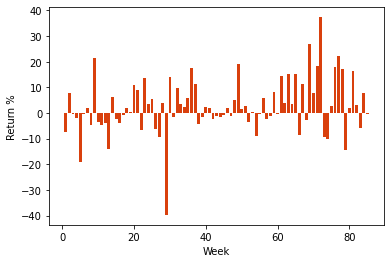

In [ ]:
plt.bar(range(1, 86), long_strategy, color=(0.85, 0.25, 0.05))
plt.xlabel('Week')
plt.ylabel('Return %')
plt.show()

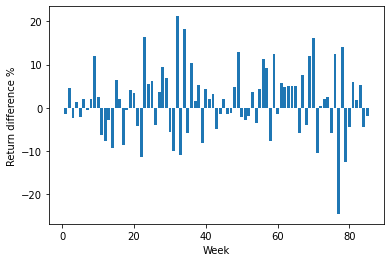

In [ ]:
plt.bar(range(1, 86), np.array(model) - np.array(base))
plt.xlabel('Week')
plt.ylabel('Return difference %')
plt.show()

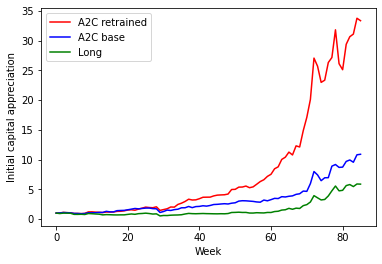

In [ ]:
plt.plot(model_comp, 'r', label='A2C retrained')
plt.plot(base_comp, 'blue', label='A2C base')
plt.plot(long_strategy_comp, 'g', label='Long')
plt.xlabel('Week')
plt.ylabel('Initial capital appreciation')
plt.legend()
plt.show()

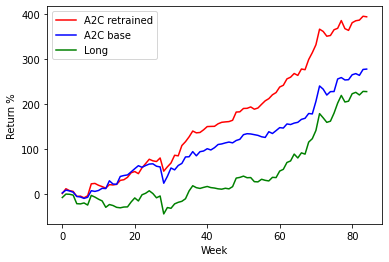

In [ ]:
plt.plot(model_cum, 'r', label='A2C retrained')
plt.plot(base_cum, 'blue', label='A2C base')
plt.plot(long_strategy_cum, 'g', label='Long')
plt.xlabel('Week')
plt.ylabel('Return %')
plt.legend()
plt.show()